In [1]:
from mm import *

In [4]:
df = pd.read_csv('price-volume-minute_btc-usd.csv',header=None)
df.columns = ['price','volume','time']
df = df.astype({'time':'datetime64[ms]'}).set_index('time').sort_index()

In [29]:
df.where(df['price'].diff() > 0)

,price,volume
time,,
2017-01-01 00:07:00,NaN,NaN
2017-01-01 00:08:00,NaN,NaN
2017-01-01 00:12:00,NaN,NaN
2017-01-01 00:13:00,NaN,NaN
2017-01-01 00:14:00,968.048176,1.929722
...,...,...
2021-08-08 23:55:00,43794.138727,0.377218
2021-08-08 23:56:00,43825.262337,4.533142
2021-08-08 23:57:00,NaN,NaN


In [32]:
def mfi(df,kandle=5):
    ddp =df.where(df['price'].diff() > 0)
    pmf = ddp['price'].rolling(kandle,1).mean()*ddp['volume'].rolling(kandle,1).sum()
    ddn =df.where(df['price'].diff() < 0)
    nmf = ddn['price'].rolling(kandle,1).mean()*ddn['volume'].rolling(kandle,1).sum()
    return 100 - 100/(1 + pmf/nmf)

In [44]:
def calc_mfi(df,kandle=5,mfi_range=14):
    dd = df.copy()
    dd['price'] = dd['price'].rolling(kandle,1).mean()
    pmf = dd.where(dd['price'].diff() > 0).rolling(mfi_range,1).agg({'price':'sum','volume':'sum'}) 
    pmf = pmf['price'] * pmf['volume']
    nmf = dd.where(dd['price'].diff() < 0).rolling(mfi_range,1).agg({'price':'sum','volume':'sum'}) 
    nmf = nmf['price'] * nmf['volume']
    return 100 - 100/(1 + pmf/nmf)

 1.0    0.562712
-1.0    0.403390
-0.0    0.033898
Name: price, dtype: float64

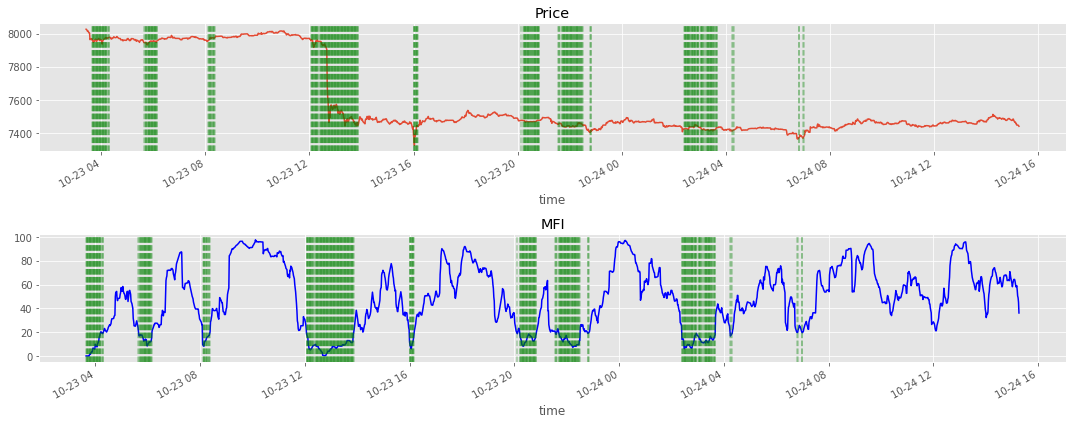

In [475]:
fig,ax = plt.subplots(2,1)
idx = np.random.randint(df.shape[0]-1000)
idx_df = df.iloc[idx-1000:idx+1000].index
df.loc[idx_df,'price'].plot(ax=ax[0],title='Price')
calc_mfi(df.loc[idx_df],kandle=5,mfi_range=5*14).plot(ax=ax[1],title='MFI',color='b')
buy_idx = calc_mfi(df.loc[idx_df],kandle=5,mfi_range=5*14).where(lambda x: x < 20).dropna().index
sell_idx = calc_mfi(df.loc[idx_df],kandle=5,mfi_range=5*14).where(lambda x: x > 80).dropna().index
[ax[0].axvline(bidx,linestyle='--',alpha=0.3,color='g') for bidx in buy_idx]
[ax[1].axvline(bidx,linestyle='--',alpha=0.3,color='g') for bidx in buy_idx]
plt.tight_layout()
(df.loc[sell_idx]['price'].resample('min').mean().fillna(method='bfill') - df.loc[buy_idx]['price'].resample('min').mean()).dropna().clip(-1,1).round().value_counts(normalize=True)

In [497]:
has_more = []
for i in tqdm(range(100)):
    idx = np.random.randint(df.shape[0]-1000)
    idx_df = df.iloc[idx-300:idx+300].index
    buy_idx = calc_mfi(df.loc[idx_df],kandle=5,mfi_range=5*6).where(lambda x: x < 20).dropna().index
    for i in buy_idx:
        has_more.append((df.loc[idx_df,'price'].loc[i:] > df.loc[i,'price']).value_counts(normalize=True))

100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


In [518]:
has_more = []
has_baseline = []
for i in range(100):
    idx = np.random.randint(df.shape[0]-1000)
    idx_df = df.iloc[idx-300:idx+300].index
    buy_idx = calc_mfi(df.loc[idx_df],kandle=5,mfi_range=1000).where(lambda x: x < 20).dropna().index
    rng_idx = df.loc[idx_df].sample(buy_idx.shape[0]).index
    for i in buy_idx:
        has_more.append((df.loc[idx_df,'price'].loc[i:] > df.loc[i,'price']).value_counts(normalize=True))
    for i in rng_idx:
        has_baseline.append((df.loc[idx_df,'price'].loc[i:] > df.loc[i,'price']).value_counts(normalize=True))


In [519]:
(pd.DataFrame(has_more)[True].mean() - pd.DataFrame(has_baseline)[True].mean())

0.004639732058672186

<AxesSubplot:>

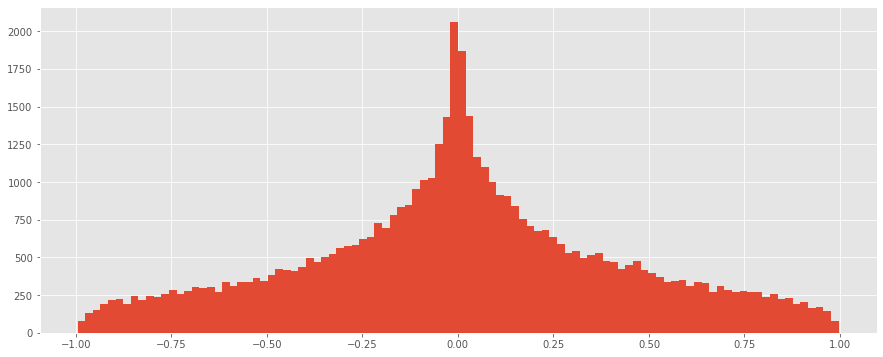

In [520]:
(pd.DataFrame(has_more)[True] - pd.DataFrame(has_baseline)[True]).hist(bins=100)

In [393]:
def omresampler(df,thr = .9,resampler = '24H'):
    if thr < 1:
        return df.resample(resampler).agg(['first','last']).where(lambda x: (x['last'] / x['first']) < thr).dropna().index
    else :
        return df.resample(resampler).agg(['first','last']).where(lambda x: (x['last'] / x['first']) > thr).dropna().index


<AxesSubplot:xlabel='time'>

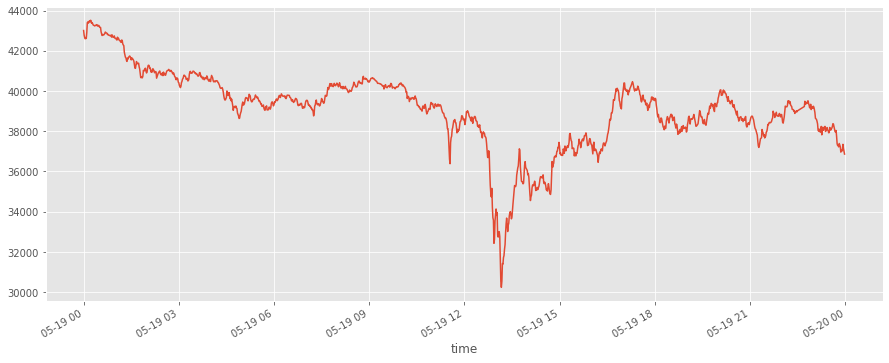

In [440]:
idx = np.datetime_as_string(np.random.choice(omresampler(df['price'].loc['2021'],thr=.9)),'D')
df.loc[str(idx),'price'].plot()

In [441]:
import optuna

'2021-05-19'

In [499]:
def hyp_obj(trial):

    kandle = trial.suggest_int('kandle_size',5,30)
    mfi_range = trial.suggest_int('mfi_range',30,2000)
    has_more = []
    for i in range(100):
        idx = np.random.randint(df.shape[0]-1000)
        idx_df = df.iloc[idx-300:idx+300].index
        buy_idx = calc_mfi(df.loc[idx_df],kandle=kandle,mfi_range=mfi_range).where(lambda x: x < 80).dropna().index
        for i in buy_idx:
            has_more.append((df.loc[idx_df,'price'].loc[i:] > df.loc[i,'price']).value_counts(normalize=True))

    return pd.DataFrame(has_more)[True].mean()

In [500]:

study = optuna.create_study(direction='maximize')
study.optimize(hyp_obj, n_trials=100)


[I 2022-04-03 18:46:03,604] A new study created in memory with name: no-name-d8c39efe-c422-4d33-9c26-b39ae28a6967
[I 2022-04-03 18:46:10,891] Trial 0 finished with value: 0.5553686143891411 and parameters: {'kandle_size': 9, 'mfi_range': 863}. Best is trial 0 with value: 0.5553686143891411.
[I 2022-04-03 18:46:20,660] Trial 1 finished with value: 0.596205084617827 and parameters: {'kandle_size': 25, 'mfi_range': 984}. Best is trial 1 with value: 0.596205084617827.
[I 2022-04-03 18:46:26,826] Trial 2 finished with value: 0.6324610182838489 and parameters: {'kandle_size': 12, 'mfi_range': 1995}. Best is trial 2 with value: 0.6324610182838489.
[I 2022-04-03 18:46:34,515] Trial 3 finished with value: 0.5685285527360122 and parameters: {'kandle_size': 13, 'mfi_range': 1753}. Best is trial 2 with value: 0.6324610182838489.
[I 2022-04-03 18:46:39,877] Trial 4 finished with value: 0.5826535663487835 and parameters: {'kandle_size': 15, 'mfi_range': 1493}. Best is trial 2 with value: 0.632461018

KeyboardInterrupt: 